# Detecção de Anomalias por Classificação de Áudio

####Por Liz Marques

#**Base de dados:** MIMII Dataset 

O MIMII (Malfunctioning Industrial Machine Investigation and Inspection)
 dataset é um conjunto de dados de áudio para investigação e inspeção de máquinas industriais com defeito. Ele contém sons gerados por quatro tipos de máquinas industriais:

  *   Válvulas Solenóide (solenoid valves)
  *   Bombas de Água (water pumps)
  *   Ventiladores Industriais (industrial fans)
  *   Trilhos Deslizantes (slide rails)


O dataset possui um total de 32.157 sons no formato wave, sendo:

*   26.092 sons normais
*   6.065 sons anômalos


Cada tipo de máquina inclui vários modelos de produtos individuais e os dados de cada modelo contêm sons normais e anômalos. Para se assemelhar a um cenário da vida real, vários sons anômalos foram gravados. Além disso, o ruído de fundo gravado em várias fábricas reais foi misturado com os sons da máquina.

Os sons anômalos contidos no dataset podem ser de difernetes naturezas como:

*   Contaminação
*   Vazamento
*   Desbalanceamento rotativo
*   Danos no trilho


Todos os arquivos de áudio utilizados neste notebook podem ser encontrados no site: https://zenodo.org/record/3384388#.Y3vbs3bMLrd

A descrição detalhada em como esta base de dados foi compilada, pode ser vista neste artigo:


*   [1] Harsh Purohit, Ryo Tanabe, Kenji Ichige, Takashi Endo, Yuki Nikaido, Kaori Suefusa, and Yohei Kawaguchi, “MIMII Dataset: Sound Dataset for Malfunctioning Industrial Machine Investigation and Inspection,” arXiv preprint arXiv:1909.09347, 2019. URL: https://arxiv.org/abs/1909.09347
*  [2] Harsh Purohit, Ryo Tanabe, Kenji Ichige, Takashi Endo, Yuki Nikaido, Kaori Suefusa, and Yohei Kawaguchi, “MIMII Dataset: Sound Dataset for Malfunctioning Industrial Machine Investigation and Inspection,” in Proc. 4th Workshop on Detection and Classification of Acoustic Scenes and Events (DCASE), 2019.

fonte: https://github.com/MIMII-hitachi/mimii_baseline

# Abordagem: Rede Neural Convolucional criada do zero
---



## Importando as bibliotecas

In [ ]:
import os
import pathlib
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import librosa
import librosa.display as ld
from IPython.display import Audio
from tqdm import tqdm                                 # para gerar barra de progresso durante a execução das tarefas
import tensorflow
print("Versão Tensorflow: ", tensorflow.__version__)
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from pathlib import Path
from collections import namedtuple
import seaborn as sns
sns.set()


## EDA - Exploratory Data Analysis

### 1º Método - Importação do dataset

In [ ]:
# Definindo o diretório
data = os.path.join("MIMII_dataset")

In [ ]:
# Caso o diretório não exista, é feita a criação
if not os.path.exists(data):
    print("O diretório data não existe. Criando-o.")
    os.makedirs(data, exist_ok=True)

In [ ]:
# Verifica se existe algum arquivo de áudio
file_verification = os.path.join(data, "fan", "id_00", "normal", "00000000.wav")
if os.path.exists(file_verification):
  print("Arquivo de áudio encontrado, não é preciso baixá-lo novamente")
    
else:
    print("Baixando e carregando o arquivo FAN 0dB do site MIMII dataset")
    # Baixando e carregando o arquivo FAN 0dB do dataset MIMII
    !wget https://zenodo.org/record/3384388/files/0_dB_fan.zip?download=1 --output-document=/tmp/fan.zip
    

    # Descompactando o arquivo
    !unzip -q /tmp/fan.zip -d $data

### 2º Método - Importação do dataset

In [ ]:
# Importando os arquivos do drive
from google.colab import drive
drive.mount('/content/gdrive')

# Descompactando os arquivos
!unzip gdrive/My\ Drive/MIMII_dataset.zip > /dev/null # > /dev/null comando para não mostrar o output
!unzip gdrive/My\ Drive/MIMII_dataset_final_test.zip > /dev/null # > /dev/null comando para não mostrar o output

Mounted at /content/gdrive


## Pré-processamento dos dados


In [ ]:
# Percorrendo os diretórios, puxando o nome dos arquivos e o seu caminho

# "namedtuple" = é como se fosse um container de dicionários que carrega chaves e valores
File = namedtuple("File", "full_path, path_parts")

# Criação de uma lista vazia que irá receber os dados
files = []

# "p" = variável que indica o caminho do dataset
p = Path("/content/MIMII_dataset")

# Iteração através dos caminhos de pastas/subpastas para encontrar os arquivos .wav
# e adicioná-los em uma lista
for item in p.glob("**/*"):
  # Verifica o que está após o ponto "."
  if item.suffix in ([".wav"]):
    # Retorna o caminho do arquivo
    full_path = Path.resolve(item).as_posix()

    # Retorna o caminho do arquivo divido em partes
    path_parts = item.parts

    # Adciona os caminhos na lista
    files.append(File(full_path, path_parts))

# Criando e vizualizando o dataframe
df = pd.DataFrame(files)
df.head()


,full_path,path_parts
0,/content/MIMII_dataset/0_dB_fan/fan/id_06/abno...,"(/, content, MIMII_dataset, 0_dB_fan, fan, id_..."
1,/content/MIMII_dataset/0_dB_fan/fan/id_06/abno...,"(/, content, MIMII_dataset, 0_dB_fan, fan, id_..."
2,/content/MIMII_dataset/0_dB_fan/fan/id_06/abno...,"(/, content, MIMII_dataset, 0_dB_fan, fan, id_..."
3,/content/MIMII_dataset/0_dB_fan/fan/id_06/abno...,"(/, content, MIMII_dataset, 0_dB_fan, fan, id_..."
4,/content/MIMII_dataset/0_dB_fan/fan/id_06/abno...,"(/, content, MIMII_dataset, 0_dB_fan, fan, id_..."


In [ ]:
# Ajustando os dados do dataframe

# Separando as colunas com os dados respectivos
df_adjust_1 = df.join(pd.DataFrame(df["path_parts"].to_list(), 
                   columns=["OUT1", "OUT2", "OUT3", "dB", "machine_type","typeID", "class", "audio_file"]))

# Deletando as colunas desnecessárias
df_adjust_2 = df_adjust_1.drop(["OUT1", "OUT2", "OUT3", "path_parts"], axis=1)


# Ordenando as colunas de forma mais coerente
df3 = df_adjust_2.reindex(columns=["machine_type", "typeID", "dB","audio_file", "class","full_path"])
df3.head()

,machine_type,typeID,dB,audio_file,class,full_path
0,fan,id_06,0_dB_fan,00000156.wav,abnormal,/content/MIMII_dataset/0_dB_fan/fan/id_06/abno...
1,fan,id_06,0_dB_fan,00000049.wav,abnormal,/content/MIMII_dataset/0_dB_fan/fan/id_06/abno...
2,fan,id_06,0_dB_fan,00000111.wav,abnormal,/content/MIMII_dataset/0_dB_fan/fan/id_06/abno...
3,fan,id_06,0_dB_fan,00000187.wav,abnormal,/content/MIMII_dataset/0_dB_fan/fan/id_06/abno...
4,fan,id_06,0_dB_fan,00000327.wav,abnormal,/content/MIMII_dataset/0_dB_fan/fan/id_06/abno...


## Visualizando a distribuição

In [ ]:
# Verificando as estatísticas dos atributos
# Podemos observar que a classe que mais se repete é a "normal"
df3.describe()

,machine_type,typeID,dB,audio_file,class,full_path
count,5550,5550,5550,5550,5550,5550
unique,1,4,1,1033,2,5550
top,fan,id_00,0_dB_fan,00000156.wav,normal,/content/MIMII_dataset/0_dB_fan/fan/id_06/abno...
freq,5550,1418,5550,8,4075,1


In [ ]:
# Quantidade de arquivos para cada classe
# Podemos observar que o dataset está desbalanceado
df3["class"].value_counts()

normal      4075
abnormal    1475
Name: class, dtype: int64

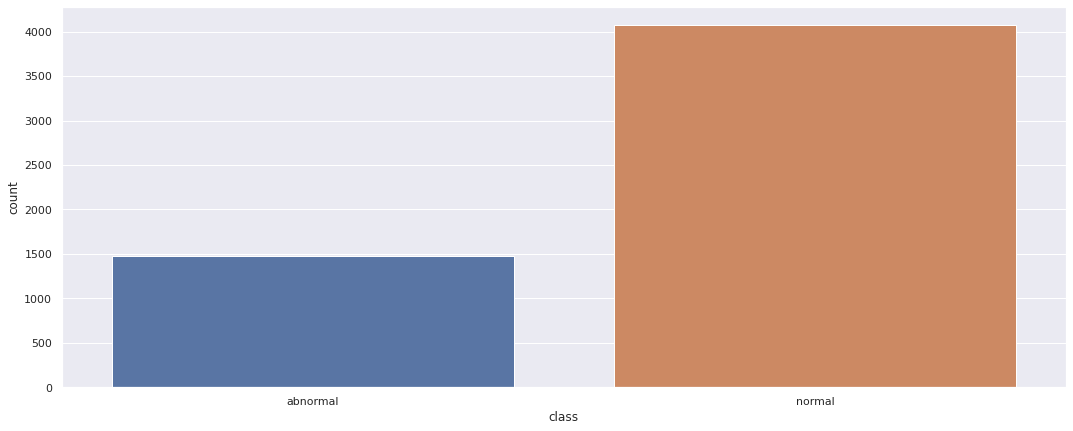

In [ ]:
# Criando um gráfico de barras
plt.figure(figsize=(18,7))
sns.countplot(df3["class"]);

### Espectrogramas de MFCC (Coeficientes Cepstral de Frequência Mel)

In [ ]:
# Filtrando por linha os arquivos desejados 
normal_raw = df3.loc[df3["class"] == "normal"].sample(n=1)
#print(normal_raw)

# Trazendo o caminho do arquivo
normal_file_path = normal_raw["full_path"].values[0]
print(normal_file_path)

# Trazendo a classe
normal_class_name = normal_raw["class"].values[0]
print(normal_class_name)

/content/MIMII_dataset/0_dB_fan/fan/id_02/normal/00000443.wav
normal


Som Normal

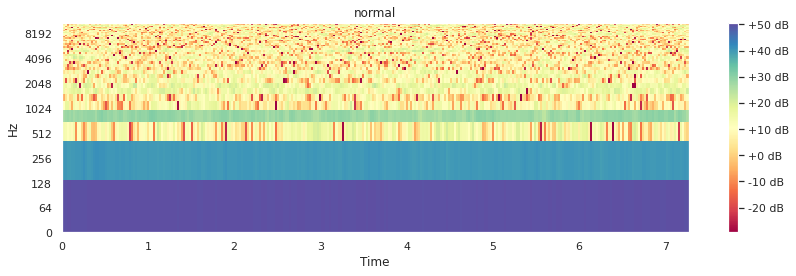

In [ ]:
# MFCC
rows = 1
cols = 1
fig, axs = plt.subplots(rows, cols, figsize=(12,4))
data, sample_rate = librosa.load(normal_file_path, sr = None) #  22050 Hz

# Gerando o mfcc
# y = corresponde as amostras de áudio
mfccs = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc=40)

# Convertendo para decibéis; np.abs = números absolutos
mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))

# log = o espectro será exibido em uma escala logarítmica
# cmap = selecionando a característica do mapa de cores
img = librosa.display.specshow(mfccs_db, x_axis="time", y_axis="log", cmap = "Spectral")
axs.set_title('{}'.format(normal_class_name))
fig.colorbar(img, format='%+2.f dB')

fig.tight_layout()

# Através do Espectrograma conseguimos observar o áudio em três domímios: tempo, frequência e amplitude.

# Escala Mel (faz uma espécie de normalização) => ela é fundamental em aplicações de ML 
# voltadas para áudio, pois ela imita as características únicas perceptíveis pelo ouvido humano.
# Ex: é muito mais fácil nós identificarmos a diferença de 100Hz-200Hz do que 10.100Hz-10.200Hz

# Podemos reparar que os espectrogramas nada mais são do que imagens, logo,
# podemos treinar uma rede neural convolucional para que ela aprenda a 
# classificar os diferentes tipos de som baseada nas diferenças dos espectrogramas mfcc.

# O espectrograma é um conjunto de características extraídas do áudio
# e, por meio dessas características, podemos visualizar estes gráficos


# Pré Processamento

### Extraindo recursos/características MFCC's de cada arquivo de áudio do dataset

In [ ]:
# Função que garante a extração das características
def features_extractor(file_paths):
  data, sample_rate = librosa.load(file_paths, sr = None, res_type = 'kaiser_fast')
  # sr(sample rate) = None; valor padrão, ou seja, 22050 Hz
  # "res_type" = tipo de carregamento
  # O "kaiser_fast" não garante tanta qualidade, mas é feito de forma rápida
  mfccs_features = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc=40)   
  # y = amostras de áudio;
  # "n_mfcc" = número de mfccs
  # O ideal é iniciar o treinamento do modelo com n_mfcc = 40. 
  # Caso não tenha bons resultados, posso ir aumentando esse número.
  mfcss_features_scaled = np.mean(mfccs_features.T, axis = 0)
  #np.mean = retorna a média dos elementos do array
  return mfcss_features_scaled

In [ ]:
extracted_features = []
# Percorrendo de cada um dos arquivos
for path in tqdm(df3["full_path"].values):
  data = features_extractor(path)
  extracted_features.append([data])

100%|██████████| 5550/5550 [05:24<00:00, 17.10it/s]


In [ ]:
# Em cada uma das posições, temos as características de cada áudio, ou seja, cada array representa um áudio específico
extracted_features

[[array([-3.3337561e+02,  1.0215569e+02, -9.8941393e+00,  1.1034073e+01,
         -5.7918324e+00, -1.0080875e+00, -5.9139977e+00,  3.3615115e+00,
          6.5690821e-01, -4.5916221e-01, -8.3611221e+00, -4.4116101e+00,
         -6.4740610e-01, -3.3037955e-01,  1.1650599e+00,  3.9403868e+00,
         -1.1744883e+00, -9.2922411e+00, -5.4038095e+00,  3.6547337e+00,
          5.4640927e+00,  1.1804464e+01,  8.5626602e+00,  1.1672344e+00,
         -1.1548873e+01, -1.2204862e+01, -2.4501395e+00,  1.9388056e+00,
         -3.9820323e+00, -9.6838398e+00, -7.7599216e+00,  8.5282308e-01,
          6.2437654e+00,  9.4144624e-01, -3.0717683e+00, -5.0086851e+00,
         -7.0141625e+00, -1.0302963e+01, -1.1769471e+01, -3.9184773e+00],
        dtype=float32)],
 [array([-3.2852829e+02,  7.5661087e+01, -1.3824905e+01,  1.1426712e+01,
         -8.4031200e+00,  1.0163946e+00, -3.1364315e+00,  5.3862934e+00,
         -7.7596551e-01,  2.8883815e-02, -2.2533221e+00, -1.6735238e+00,
          4.6316305e-01, 

In [ ]:
# Total de arrays
len(extracted_features)

5550

In [ ]:
# Valores/características do primeiro áudio
extracted_features[0]

[array([-3.3337561e+02,  1.0215569e+02, -9.8941393e+00,  1.1034073e+01,
        -5.7918324e+00, -1.0080875e+00, -5.9139977e+00,  3.3615115e+00,
         6.5690821e-01, -4.5916221e-01, -8.3611221e+00, -4.4116101e+00,
        -6.4740610e-01, -3.3037955e-01,  1.1650599e+00,  3.9403868e+00,
        -1.1744883e+00, -9.2922411e+00, -5.4038095e+00,  3.6547337e+00,
         5.4640927e+00,  1.1804464e+01,  8.5626602e+00,  1.1672344e+00,
        -1.1548873e+01, -1.2204862e+01, -2.4501395e+00,  1.9388056e+00,
        -3.9820323e+00, -9.6838398e+00, -7.7599216e+00,  8.5282308e-01,
         6.2437654e+00,  9.4144624e-01, -3.0717683e+00, -5.0086851e+00,
        -7.0141625e+00, -1.0302963e+01, -1.1769471e+01, -3.9184773e+00],
       dtype=float32)]

In [ ]:
# Verificando o shape
# 1 linha e 40 colunas
# Ou seja, temos 40 caracteríticas
np.array(extracted_features[0]).shape

(1, 40)

## Convertendo os recursos extraídos para visualização com Pandas

In [ ]:
# Neste seguimento, faremos os ajustes para deixar os dados aptos para a rede neural
extracted_features_df = pd.DataFrame(extracted_features, columns = ['feature'])
extracted_features_df.head()

,feature
0,"[-333.3756, 102.15569, -9.894139, 11.034073, -..."
1,"[-328.5283, 75.66109, -13.824905, 11.426712, -..."
2,"[-388.05032, 118.16451, -1.4647326, 1.8308384,..."
3,"[-330.21304, 112.47484, -13.158821, 22.86337, ..."
4,"[-383.1901, 125.69392, -6.994615, 30.823698, -..."


## Dividindo entre atributos classe (class) e atributos previsores (features)

In [ ]:
# Quando trabalhamos com  aprendizagem de máquina, é comum denominarmos o X com os atributos previsores
# Neste caso, as características mfccs.
X = np.array(extracted_features_df['feature'].tolist())

# E o Y com as informações relacionadas com a classe
y = np.array(df3["class"].tolist())

In [ ]:
# 5550 linhas, ou seja, os sons
# 40 colunas, ou seja, as características mfccs
X.shape

(5550, 40)

In [ ]:
# Conversão dos dados categóricos (string) em dados numéricos na variável Y (classe)
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
# Separando o dataset em treino, teste e validação

# Definimos 80% dos dados para variável x_train
# Dos 20% restantes:
# Definimos 50% desses dados para a variável  x_test
# Definimos 50% desses dados para a variável  x_val

# Após cada uma das épocas do treinamento da rede neural, nós vamos enviar os dados
# para avaliar o desempenho (x_val)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state=1)

In [ ]:
# 80% dos dados
X_train.shape

(4440, 40)

In [ ]:
# 20% dos dados: 50% para teste e 50% para validação
X_test.shape, X_val.shape

((555, 40), (555, 40))

In [ ]:
# Adicionando uma nova dimensão (np.newaxis).
# Os dois pontos (:) indicam que vamos manter a quantidade de registros 
# e a quantidade de colunas. E , ao final, adicionamos a nova dimensão.
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_val = X_val[:,:,np.newaxis]

In [ ]:
# Verificando o shape de todas as variáveis, podemos observar que foi adicionada mais uma dimensão.
# Como a rede neural convolucional é utilizada principalmente para classificação de imagens,
# esse último valor indica o número de canais.
# Uma imagem em escala de cinza possui 1 canal, uma imagem colorida, por sua vez, possui 3 canais.
# Essa última dimensão foi adicionada mais com o intuito de que os dados estivessem no padrão correto para o Tensorflow. 
# Na prática, não será adicionado nenhum tipo de informação nela.
X_train.shape, X_test.shape, X_val.shape

((4440, 40, 1), (555, 40, 1), (555, 40, 1))

# Criação do modelo

### Criação da estrutura da rede neural

Os espectrogramas extraídos dos arquivos de áudio são como imagens 2D, então podemos usar técnicas de classificação de imagens neles, especificamente Redes Neurais Convolucionais (CNN)!

A arquitetura desta rede neural foi definida com base em alguns testes realizados para obter o resultado esperado. A estrutura pode ser ajustada livremente e comparada aos resultados desta estrutura.

 * Parâmetros: 
  * `Sequential`, é a classe para criar a rede neural, pois uma rede neural nada mais é que uma sequência de camadas (camada e entrada, camadas ocultas, camada de saída);  
  * `kernel_size`, o tamanho do kernel (matriz) de convolução;
  * `activation`, função de ativação;
  * `input_shape`, na primeira camada este é o tamanho dos dados de entrada
  * Camada `MaxPooling1D`, que vai fazer a extração das características principais;
  * Camada `Conv1d`, uma rede neural convolucional que realiza a convolução ao longo de apenas uma dimensão;
  * Camada `Flatten`, para transformar de matriz em vetor;
  * Camada `Dense`, quando um neurônio de uma camada está ligado a todas os outros neurônios das outras camadas;
  * `Dropout`, técnica de regularização para diminuir o overfitting: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
  * `padding='same'`, indica que adicionamos uma nova coluna composta por somente 0 (zeros) e utilizamos toda a imagem: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow/


In [ ]:
# OBSERVAÇÃO: AQUI ESTAMOS CRIANDO UMA ESTRUTURA DE REDE NEURAL CONVOLUCIONAL BEM SIMPLES COM SOMENTE 2 BLOCOS CONVOLUCIONAIS.
# CASO SEJA NECESSÁRIO, É POSSÍVEL ALTERAR ESSA ESTRUTURA.

# Variável "model" - nosso modelo/rede neural
# Será um objeto da classe sequencial, já que uma rede neural é uma sequência de
# camadas 
model = Sequential()

# 1º BLOCO  
# "add(Conv1D)" = camada convolucional com 1 dimensão; utilizamos 64 filtros; 
# kernel size = 10 indica uma matrix 10x10 (10 linhas e 10 colunas); fará os cálculos de multiplicação e somatório aplicado na imagem
# Função de ativação = Relu -> indicada para camadas ocultas; 
# input_shape = indica como os dados estão na camada de entrada
model.add(Conv1D(64, kernel_size=(10), activation="relu", input_shape=(X_train.shape[1], 1)))

# "add(Dropout)" = camada de dropout => técnica para prevenir a ocorrência de overfitting
# No dropout são escolhidas uma porcentagem de neurônios que serão excluídos durante o processo de treinamento
# 20%, 30% ou até 40% dos neurônios serão zerados/não utilizados.
# Neste caso, vamos zerar 40% dos neurônios
model.add(Dropout(0.4))

# "add(MaxPooling1D)" = camada de maxpooling
# pool_size será igual a uma matrix 4x4 => a qual fará os cálculos para selecionar os maiores valores
model.add(MaxPooling1D(pool_size=(4)))

# 2º BLOCO
# "add(Conv1D)" = camada de convolução
# Vamos selecionar 128 filtros; kernel_size será igual matrix 10x10
# padding = indica o preenchimento; 
# padding = same; indica que será adicionada mais uma coluna composta por zeros
model.add(Conv1D(128, 10, padding="same",))

# "add(Activation('relu'))" = camada de ativação relu
model.add(Activation("relu"))

# Neste caso, vamos zerar 40% dos neurônios
model.add(Dropout(0.4))

# pool_size será igual a uma matrix 4x4 
model.add(MaxPooling1D(pool_size=(4)))

# "add(Flatten())" = camada para converter uma matriz em um vetor
model.add(Flatten())

# Bloco do Classificador
# "add(Dense)" = camada de convolução
# units = 64; indica a quantidade de neurônios na camada de entrada da rede neural densa
model.add(Dense(units = 64))
model.add(Dropout(0.4))
model.add(Dense(units = 2))
# "Sigmoid" = caso binário (som normal ou som anômalo)
model.add(Activation("sigmoid"))

In [ ]:
# Compilando a rede neural
# loss = função de perda
# "adam" = > Padrão de uso para o cenário de deep learning
# O "adam" é uma versão melhorada da Descida do Gradiente
model.compile(loss= "binary_crossentropy", metrics = ["accuracy"], optimizer = "adam")

# Observando a estrutura da rede neural convolucional
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 31, 64)            704       
                                                                 
 dropout (Dropout)           (None, 31, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 128)            82048     
                                                                 
 activation (Activation)     (None, 7, 128)            0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 128)            0         
                                                        

# Treinamento o modelo
 * `num_epochs`, número de épocas de treinamento
 * `num_batch_size`, isto indica que vamos enviar de 32 em 32 recursos de áudio (32, 64, 96, 128,...8732)

ModelCheckpoint, para salvar o modelo enquanto faz o treinamento
 * `filepath`, caminho onde será salvo o modelo. Para isto temos uma pasta no Drive chamada *saved_models*
 * `verbose`, mostrar mensagens enquanto a rede neural é treinada
 * `save_best_only = True`, para salvar o modelo somente quando houver uma melhora no resultado

Variáveis para efetuar a contagem do tempo de treinamento:
 * `start`, pegando o horário atual de início do treinamento;
 * `duration`, ao final do treinamento, subtrair a hora atual com hora de início do treinamento.

`model_history` para armazenar o histórico de treinamento:
 * `model.fit` para fazer o ajuste do pesos ao longo do treinamento
  * `X_train`, `Y_train`, dados de treinamento
  * `batch_size = num_batch_size` que definimos acima
  * `epochs = num_epochs` que também definimos acima
  * `validation_data=(X_test, Y_test)`, dados de teste para monitorarmos como está o percentual de acerto da rede neural a cada época
  * `callbacks=[checkpointer]`, checkpointer definido anteriormente
  * `verbose = 1`, para mostrar as mensagens

In [ ]:
# Total de épocas do treinamento
num_epochs = 40

# Enviar para a rede neural de 32 em 32 áudios
num_batch_size = 32

# Salvando os modelos com os melhores resultados
checkpointer = ModelCheckpoint(filepath = "saved_models/audio_anomaly_detection.hdf5",
                               verbose = 1, save_best_only = True)

# Definindo o earlystopping para evitar o overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Variável para marcar o início do treinamento
start = datetime.now()

# Treinamento do modelo
history = model.fit(X_train, y_train, batch_size = num_batch_size, epochs = num_epochs,
                    validation_data = (X_val, y_val), callbacks = [checkpointer, callback], verbose = 1)
# Calculando o tempo do treinamento
duration = datetime.now() - start
print("Duração do treinamento: ", duration)

Epoch 1/40
135/139 [============================>.] - ETA: 0s - loss: 1.8850 - accuracy: 0.6685
Epoch 1: val_loss improved from inf to 0.52798, saving model to saved_models/audio_anomaly_detection.hdf5
139/139 [==============================] - 3s 16ms/step - loss: 1.8490 - accuracy: 0.6714 - val_loss: 0.5280 - val_accuracy: 0.7550
Epoch 2/40
138/139 [============================>.] - ETA: 0s - loss: 0.5411 - accuracy: 0.7536
Epoch 2: val_loss improved from 0.52798 to 0.46213, saving model to saved_models/audio_anomaly_detection.hdf5
139/139 [==============================] - 2s 11ms/step - loss: 0.5409 - accuracy: 0.7536 - val_loss: 0.4621 - val_accuracy: 0.7730
Epoch 3/40
138/139 [============================>.] - ETA: 0s - loss: 0.4429 - accuracy: 0.8064
Epoch 3: val_loss improved from 0.46213 to 0.31848, saving model to saved_models/audio_anomaly_detection.hdf5
139/139 [==============================] - 2s 11ms/step - loss: 0.4429 - accuracy: 0.8063 - val_loss: 0.3185 - val_accurac

# Avaliação do modelo

### Exbindo as métricas de precisão e perda do modelo
* `accuracy` e `loss` são as métricas na base de dados de treinamento;
* `val_accuracy`, `val_loss` são as métricas na base de dados de teste;

In [ ]:
# Verificando o score com a base de dados de treinamento
# Accuracy => Esse valor não é tão interessante, pois 
# neste caso a rede neural está sendo treinada e avaliada com os mesmos dados
score = model.evaluate(X_train, y_train)
score

139/139 [==============================] - 0s 3ms/step - loss: 0.0628 - accuracy: 0.9838


[0.06276709586381912, 0.9837837815284729]

In [ ]:
# Verificando o score com a base de dados de validação
# Neste caso, a rede neural está sendo avaliada com dados diferentes do que foi treinada
# Erro um pouco maior e o accuracy um pouco menor também. É normal que isso ocorra
score = model.evaluate(X_val, y_val)
score

18/18 [==============================] - 0s 5ms/step - loss: 0.0861 - accuracy: 0.9694


[0.0861034244298935, 0.9693693518638611]

In [ ]:
# Verificando o score com a base de dados de teste
score = model.evaluate(X_test, y_test)
score

18/18 [==============================] - 0s 3ms/step - loss: 0.0996 - accuracy: 0.9694


[0.09957782179117203, 0.9693693518638611]

### Comparando as classes reais com as classes previstas

In [ ]:
# Aqui temos as previsões para todos os registros de teste
predictions = model.predict(X_test)
predictions, predictions.shape

18/18 [==============================] - 0s 4ms/step


(array([[0.32997605, 0.67096114],
        [0.9556143 , 0.04457163],
        [0.00234396, 0.997802  ],
        ...,
        [0.4719732 , 0.527983  ],
        [0.00779495, 0.9921571 ],
        [0.99221367, 0.00762581]], dtype=float32), (555, 2))

In [ ]:
# Aqui temos os índices que correspondem a classificação
# As classes estão na faixa de 0 a 1, pois existem 2 tipos de sons a serem classificados
predictions = predictions.argmax(axis = 1)
predictions

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# Aqui vamos transformar esses números nos nomes das classes
# Recriando a variável predictions; flatten = para achatar a matriz - transformando em formato de vetor
predictions = predictions.astype(int).flatten()

# labelencode.inverse =  transformação inversa
predictions = (labelencoder.inverse_transform((predictions)))
predictions

array(['normal', 'abnormal', 'normal', 'abnormal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'abnormal', 'abnormal', 'normal', 'normal',
       'abnormal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'abnormal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'abnormal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'abnormal', 'normal',
       'normal', 'abnormal', 'normal', 'abnormal', 'normal', 'abnormal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'abnormal',
       'normal', 'abnormal', 'normal', 'abnormal', 'abnormal', 'normal',
       'abnormal', 'abnormal', 'normal', 'normal', 'normal', 'abnormal',
       'normal', 'normal', 'normal', 'normal', 'abnormal', 'abnormal',
       'abnormal', 'abnormal', 'normal', 'normal', 'normal', 'abnormal',
       'normal', 'normal', 'abnormal', 'normal', 'normal', 'normal',
       'normal

In [ ]:
# Colocando o resultado acima em um dataframe
predictions = pd.DataFrame({'Classes previstas': predictions})
predictions

,Classes previstas
0,normal
1,abnormal
2,normal
3,abnormal
4,normal
...,...
550,normal
551,abnormal
552,normal
553,normal


In [ ]:
# Valores reais
y_test

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
# Realizando o mesmo procedimento, só que para a classe real
actual = y_test.argmax(axis = 1)
actual = actual.astype(int).flatten()
actual = labelencoder.inverse_transform(actual)
actual = pd.DataFrame({"Classes reais": actual})
actual

,Classes reais
0,abnormal
1,abnormal
2,normal
3,abnormal
4,normal
...,...
550,normal
551,abnormal
552,abnormal
553,normal


In [ ]:
# Juntando as duas colunas: classe real e classe prevista
final_df = actual.join(predictions)
final_df

,Classes reais,Classes previstas
0,abnormal,normal
1,abnormal,abnormal
2,normal,normal
3,abnormal,abnormal
4,normal,normal
...,...,...
550,normal,normal
551,abnormal,abnormal
552,abnormal,normal
553,normal,normal


### Matriz de confusão

In [ ]:
# Todas as classes extraídas
labelencoder.classes_

array(['abnormal', 'normal'], dtype='<U8')

In [ ]:
# Visualizando a matriz de confusão em formato de dataframe
cm = confusion_matrix(actual, predictions)
cm = pd.DataFrame(cm, index = [i for i in labelencoder.classes_], columns = [i for i in labelencoder.classes_])
cm

,abnormal,normal
abnormal,151,8
normal,9,387


Text(84.5, 0.5, 'Classes reais')

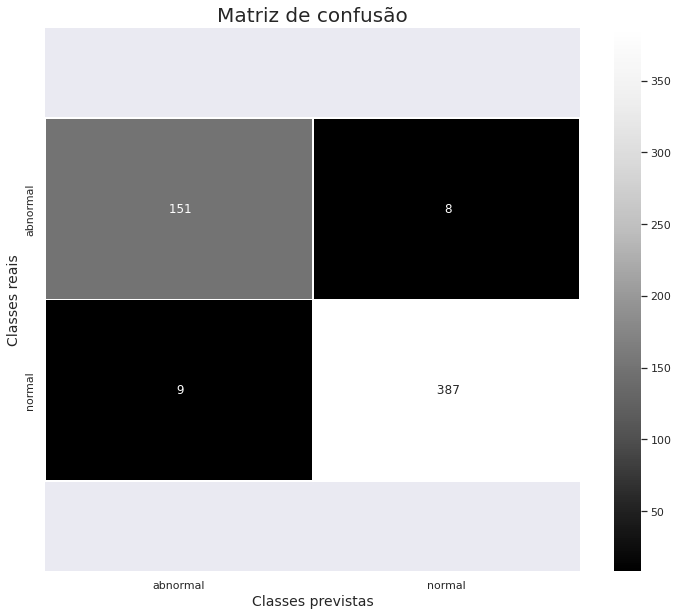

In [ ]:
# Gerando a matriz de confusão em formato de gráfico
# annot = True; para mostrar os valores
plt.figure(figsize = (12,10))
ax = sns.heatmap(cm, linecolor = "white", cmap = "Greys_r", linewidth=1, annot = True, fmt = " ")

# Para a delimitação do gráfico na parte superior e inferior
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Matriz de confusão", size = 20)
plt.xlabel("Classes previstas", size = 14)
plt.ylabel("Classes reais", size = 14)

### Visualizando a taxa e acerto para cada uma das classes

 * precision, é a precisão da classificação
 * recall, define a porcentagem que o algoritmo consegue identificar determinada classe

Neste link tem alguns bons exemplos explicando um pouco mais sobre estas e outras métricas de avaliação e a importância de cada uma:
[Confusion Matrix, Accuracy, Precision, Recall, F1 Score](https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd)

In [ ]:
# Verificando a métrica
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

    abnormal       0.94      0.95      0.95       159
      normal       0.98      0.98      0.98       396

    accuracy                           0.97       555
   macro avg       0.96      0.96      0.96       555
weighted avg       0.97      0.97      0.97       555



# Testando o modelo em arquivos de áudio

In [ ]:
def get_info(data, sample_rate):
  print("Canais: ", len(data.shape))
  print("Número total de amostras: ", data.shape[0])
  print("Taxa de amostragem: ", sample_rate)
  print("Duração: ", len(data) / sample_rate)

In [ ]:
def predict_sound(arquivo_audio, info = False, plot_waveform = False, plot_spectrogram = False):
  # Fazendo o pré-processamento dos dados
  # Carregando o áudio
  audio, sample_rate = librosa.load(arquivo_audio, sr = None, res_type = "kaiser_fast")

  # Extração de características MFCCs
  mfccs_features = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc=40)

  # Aplicando a normalização
  mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)

  # Convertendo de vetor para matriz, pois precisamos enviar os dados para o Tensorflow
  mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)

  #  Adicionando a 3ª dimensão (cor)
  mfccs_scaled_features = mfccs_scaled_features[:,:,np.newaxis]

  # Gerando as probabilidades para cada classe
  prediction = model.predict(mfccs_scaled_features)

  # Extraindo o maior valor; argmax(axis=1) = para considerar as colunas
  prediction = prediction.argmax(axis=1)

  # astype(int) = Convertendo os valores para números inteiros; flatten() = transformando para vetor
  prediction = prediction.astype(int).flatten()
  
  # inverse_transform(()) = Trazendo os nomes das classes
  prediction = labelencoder.inverse_transform((prediction))

  print("Classificação/resultado: ", prediction)

  if info:
    get_info(audio, sample_rate)

  # Gerando a waveform
  if plot_waveform:
    plt.figure(figsize=(14,5))
    plt.title("Tipo de som: " + str(prediction[0].upper()), size = 16)
    plt.xlabel("Tempo")
    plt.ylabel("Amplitude")
    ld.waveplot(audio, sr=sample_rate)
    #ld.waveshow(audio, sr=sample_rate)

  # Gerando o espectrograma
  if plot_spectrogram:
    plt.figure(figsize=(14,5))
    mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
    plt.title("Tipo de som: " + str(prediction[0].upper()), size = 16)
    ld.specshow(mfccs_db, x_axis="time", y_axis="log", cmap="Spectral")
    plt.colorbar(format='%+2.f dB')

In [ ]:
# Carregando e escutando o áudio
audio, sample_rate = librosa.load("/content/MIMII_dataset_final_test/-6_dB_fan/id_06/abnormal/00000003.wav", sr = None, res_type = "kaiser_fast")
Audio(data = audio, rate = sample_rate)

In [ ]:
# Fazendo a previsão
predict_sound("/content/MIMII_dataset_final_test/-6_dB_fan/id_06/abnormal/00000003.wav", info = True, plot_waveform=True, plot_spectrogram=True)